Using Tensorflow Object detection API to detect mushrooms in images

In [1]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)


2.17.0


In [2]:
# Functions for displaying images and drawing bounding boxes on them
def display_image(image):
  plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def load_img_from_path(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img


def draw_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size

  (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)

  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
  # If the total height of the display strings added to the top of the bounding box exceeds the top of the image, stack the strings below the bounding box instead of above.
  display_str_heights = [font.getbbox(ds)[3] for ds in display_str_list]
  # Calculate the total height to display text
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)
  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top
  for display_str in display_str_list[::-1]:
    bbox = font.getbbox(display_str)
    text_width, text_height = bbox[2], bbox[3]
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
    draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)
    text_bottom -= text_height - 2 * margin
  

In [3]:
# Function for drawing a box around the object
def draw_box_on_object(image, boxes, class_names, scores, max_boxes=5, min_score=0.1):
    colors = list(ImageColor.colormap.values())
    font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i].any() >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

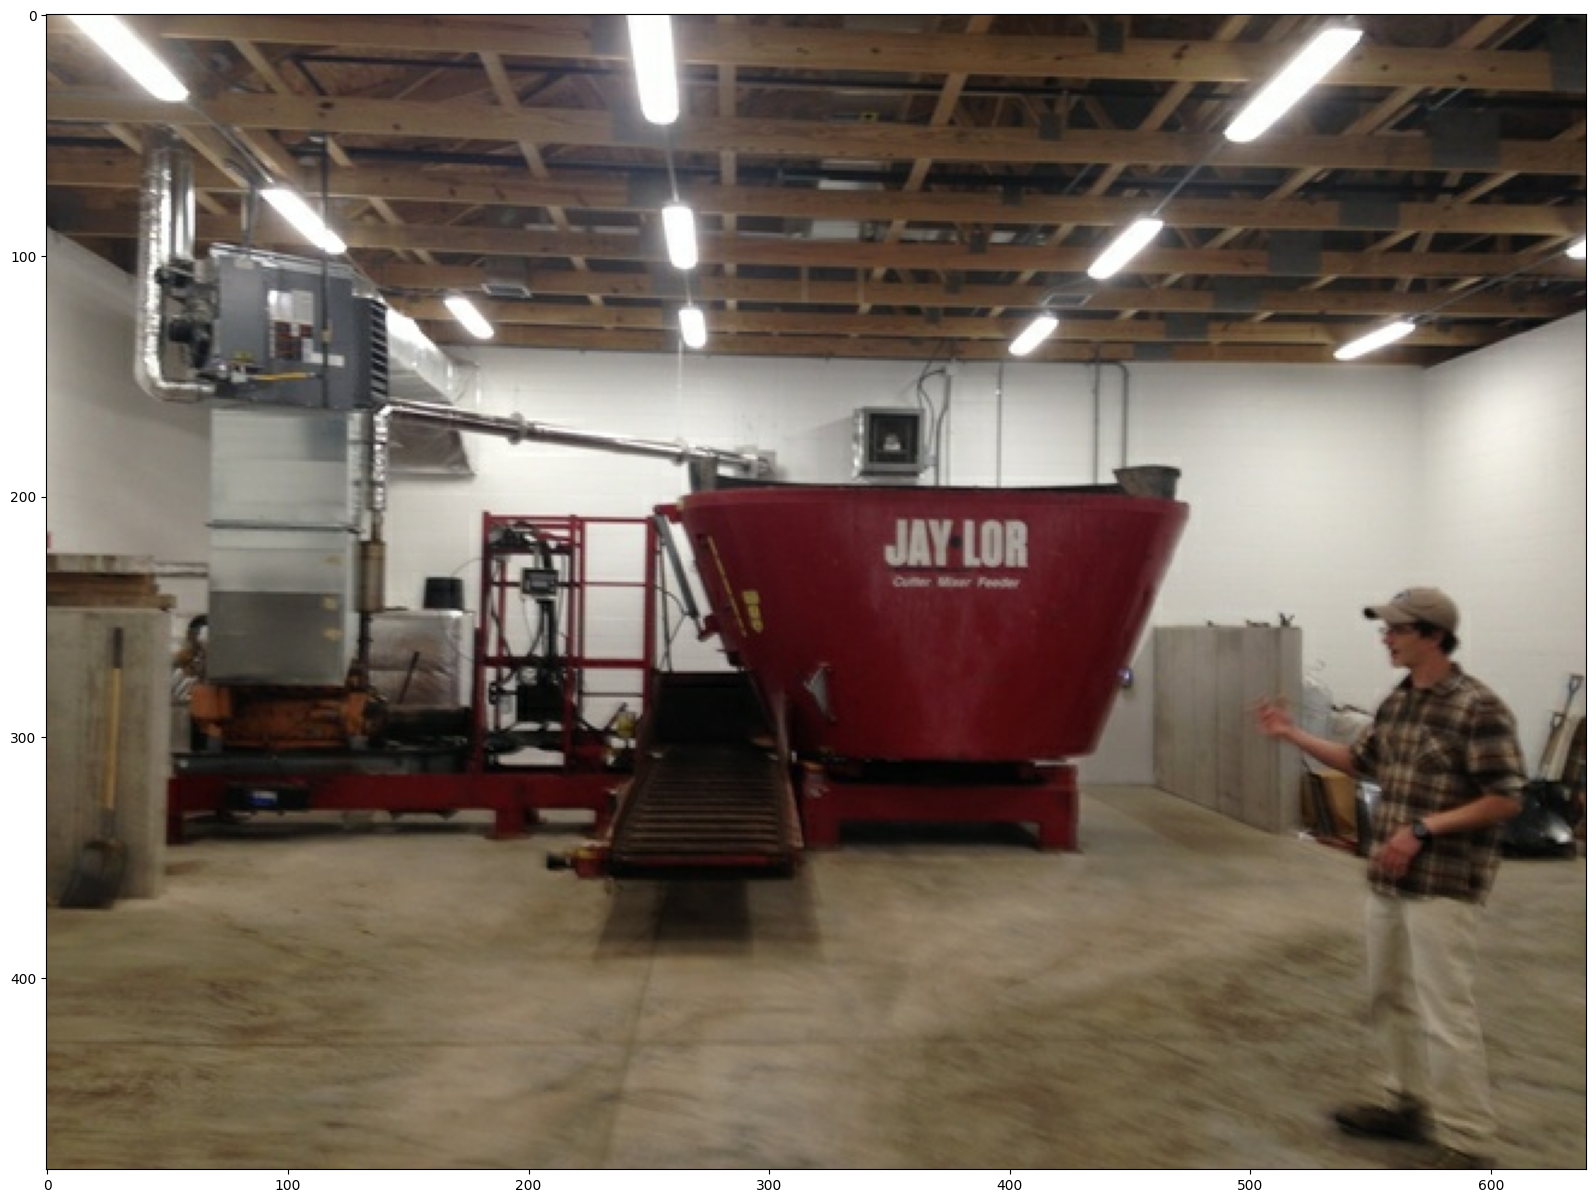

In [4]:
sample_image_path = 'mushrooms_dataset/images/Agaricus_bisporus/614156.jpg'
image = load_img_from_path(sample_image_path)
display_image(image)
# image = Image.open(sample_image_path + '.jpg').resize((640,640))

In [5]:
# Now we load the TF-Hub module
# module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

#TODO use YOLO model
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Found 100 objects.
Inference time:  5.71265435218811


{'detection_class_labels': array([462,  69, 433,  69, 434, 434, 434, 502, 434, 434, 308, 218, 434,
        433, 434, 409, 218,  43, 434, 434, 409, 218, 434, 462, 218, 433,
        308, 434, 434, 434, 218, 434,  69,  97, 218, 434, 434, 409, 218,
        485, 218, 103, 433, 409, 434, 393, 409, 393, 218, 103, 462,  69,
        485, 218, 103, 462, 433, 218,  69, 485, 462, 462, 409, 462, 462,
         97, 433, 462, 218, 409, 485, 485, 485, 218, 485, 281,  97,  69,
        462, 253,  97,  97, 218, 103, 462, 218, 434, 462, 409,  97, 393,
        218, 218, 409,  97, 434, 409, 485,  69, 485], dtype=int64),
 'detection_class_names': array([b'/m/0cgh4', b'/m/01g317', b'/m/09j2d', b'/m/01g317', b'/m/09j5n',
        b'/m/09j5n', b'/m/09j5n', b'/m/0dzct', b'/m/09j5n', b'/m/09j5n',
        b'/m/04yx4', b'/m/033rq4', b'/m/09j5n', b'/m/09j2d', b'/m/09j5n',
        b'/m/083wq', b'/m/033rq4', b'/m/019jd', b'/m/09j5n', b'/m/09j5n',
        b'/m/083wq', b'/m/033rq4', b'/m/09j5n', b'/m/0cgh4', b'/m/033rq4',

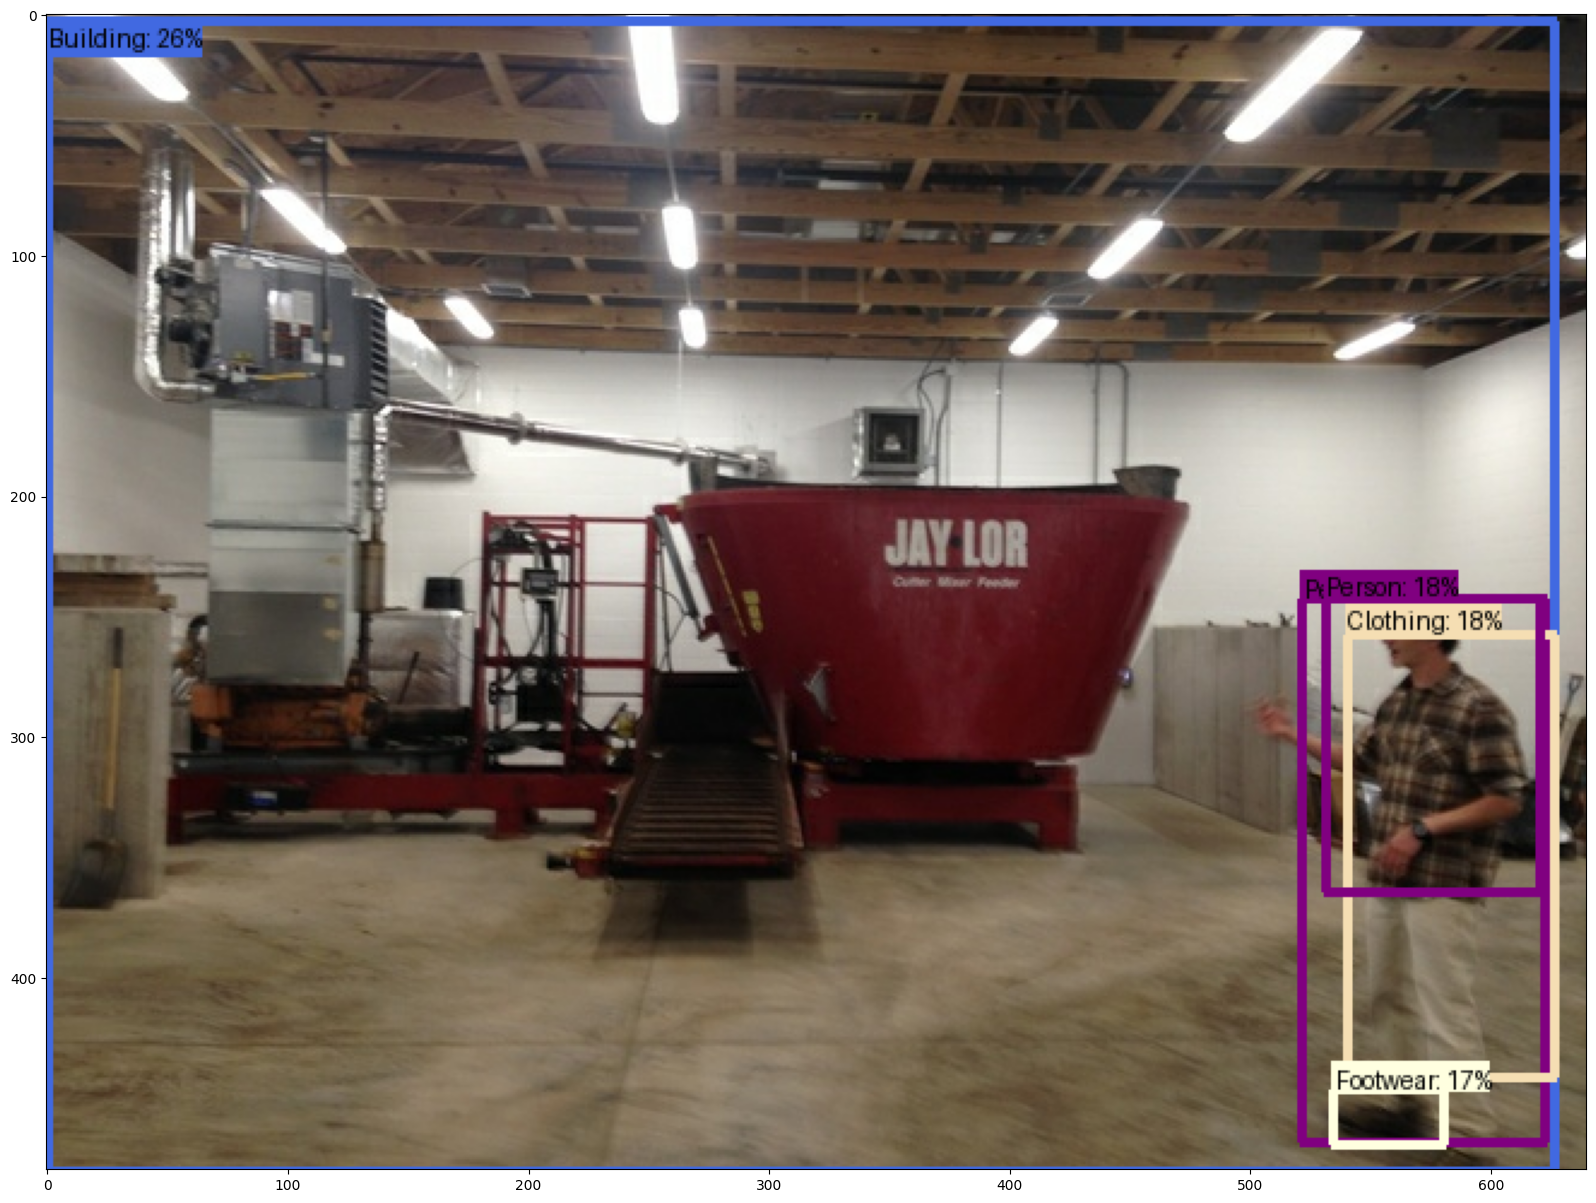

In [6]:
def run_detector(detector, image, display_img=True):
  img = load_img_from_path(image)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()


  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)
  
  image_with_boxes = draw_box_on_object(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])
  
  if display_img:
    display_image(image_with_boxes)

  return result
  

run_detector(detector, sample_image_path, display_img=True)

Found 100 objects.
Inference time:  0.04127240180969238


{'detection_class_labels': array([315, 217, 276, 203, 334, 334, 334, 334, 334, 334, 315, 334, 334,
        315, 334, 315, 334, 334, 334, 334, 334, 334, 334, 334,  38, 334,
        334, 315, 334, 334, 334, 334, 334, 334, 315, 334, 334, 334, 334,
        334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334,
        334, 334, 334, 334, 334, 334, 334, 334, 334, 315, 334, 334, 334,
        334, 315, 334, 315,  74, 334, 334, 334, 334, 334, 334, 334, 334,
        334, 334, 334, 334, 334, 315, 334, 334, 334, 334, 334, 334, 334,
        334, 334, 502, 334, 334, 334, 334, 334, 334], dtype=int64),
 'detection_class_names': array([b'/m/052sf', b'/m/033cnk', b'/m/044r5d', b'/m/02xwb', b'/m/05s2s',
        b'/m/05s2s', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s',
        b'/m/052sf', b'/m/05s2s', b'/m/05s2s', b'/m/052sf', b'/m/05s2s',
        b'/m/052sf', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s',
        b'/m/05s2s', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s', b'/m/018xm',
   

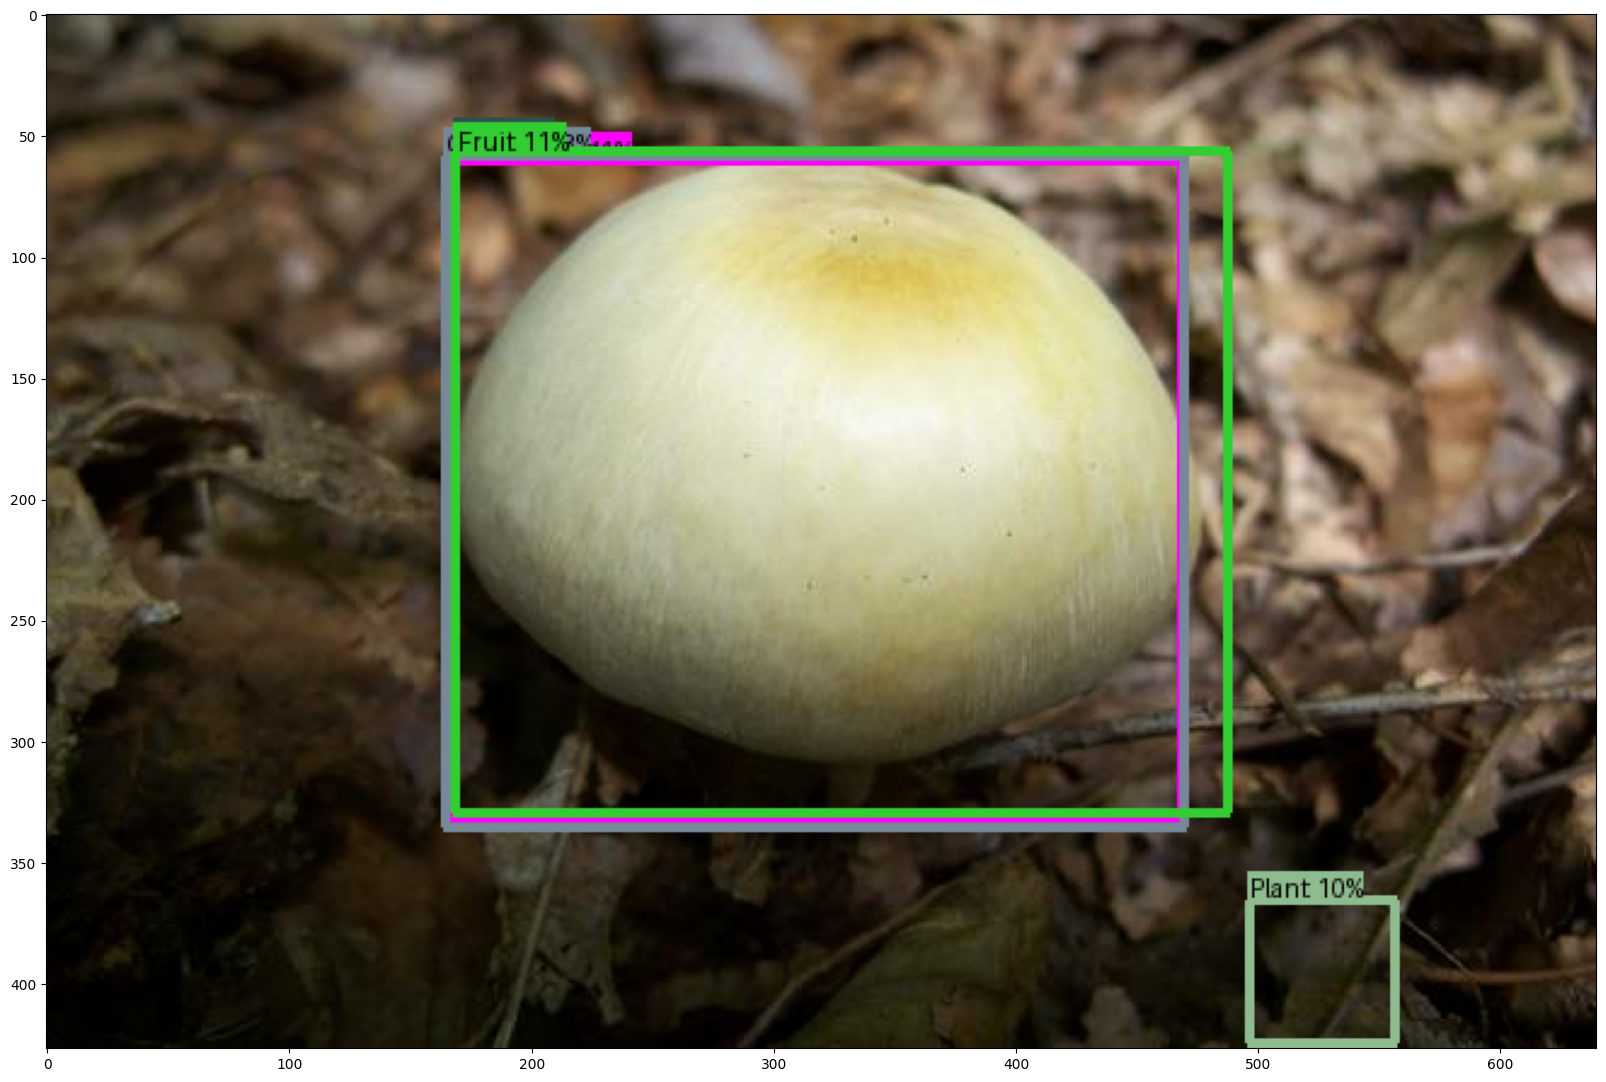

In [7]:
run_detector(detector,'mushrooms_dataset/images/Agaricus_abruptibulbus/60416.jpg', display_img=True)

In [8]:
run_detector(detector,'mushrooms_dataset/images/Agaricus_bisporus/869.jpg',display_img=False)

Found 100 objects.
Inference time:  0.029855728149414062


{'detection_class_labels': array([315, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334,
        334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334,
        334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334,
        334, 334, 315, 334, 334, 334, 334, 456, 334, 334, 334, 334, 334,
        334, 334, 334, 334, 334, 334, 315, 334, 334, 334, 334, 334, 334,
        391, 334, 334, 334, 334, 334, 334, 334, 334, 334, 315, 334, 334,
        334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334,
        334, 334, 334, 334, 334, 334, 334, 334, 334], dtype=int64),
 'detection_class_names': array([b'/m/052sf', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s',
        b'/m/05s2s', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s',
        b'/m/05s2s', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s',
        b'/m/05s2s', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s',
        b'/m/05s2s', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s', b'/m/05s2s',
     

Skrypt do wykrywania czy na zdjeciu jest grzyb i selekcji zdjecia do odpowiednich kaatalogow

In [9]:
import os
import shutil

input_dir = 'mushrooms_dataset/images'
subdirs = [os.path.join(input_dir, subdir).replace('\\', '/') for subdir in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, subdir))]

output_dir_correct = 'mushrooms_dataset/images_FasterRCNN/images_correct'
output_dir_incorrect = 'mushrooms_dataset/images_FasterRCNN/images_incorrect'

len(subdirs)


1249

In [ ]:
def process_images(detector, output_dir_correct, output_dir_incorrect):
    #lets iterate just for test for 100 images
    detected = False
    detected_threshold = 0.05
    for subdir in subdirs:
        for image_path in os.listdir(subdir):
            image_path = os.path.join(subdir, image_path)
            print(f'Processing image {image_path}')

            subdir_name = os.path.basename(subdir)
            image_name = os.path.basename(image_path)

            result = run_detector(detector, image_path, display_img=False)
            for score, label in zip(result['detection_scores'], result['detection_class_entities']):
                if label == b'Mushroom':
                    if score >= detected_threshold:
                        detected = True
                        break
                    else:
                        detected = False
                else:
                    detected = False


            if detected:
                correct_image_path =  os.path.join(output_dir_correct, subdir_name)
                os.makedirs(correct_image_path, exist_ok=True)
                output_dir = os.path.join(correct_image_path, image_name)
            else:
                incorrect_image_path =  os.path.join(output_dir_incorrect, subdir_name)
                os.makedirs(incorrect_image_path, exist_ok=True)
                output_dir = os.path.join(incorrect_image_path, image_name)
            
            shutil.copy(image_path, output_dir)
            print(f'Image {image_path} was copied to {output_dir}')

process_images(detector, output_dir_correct, output_dir_incorrect)



In [1]:
#Make a file with mushroom names
import os
def get_mushroom_names():
    mushroom_names = []
    for mushroom in os.listdir('mushrooms_dataset/images'):
        mushroom_names.append(mushroom)
    with open('mushroom_names.txt', 'w') as f:
        for item in mushroom_names:
            f.write("%s\n" % item)


In [2]:
get_mushroom_names()